### import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom

from keras import layers
from keras.applications import DenseNet121, ResNet50V2, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from keras.utils import Sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2

import keras.metrics as M
import tensorflow_addons as tfa
import pickle
from tensorflow.keras.utils import Sequence

from keras import backend as K

import tensorflow as tf
from tensorflow.python.ops import array_ops

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings(action='once')

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2 
import pydicom
df = pd.read_csv('/kaggle/input/oytlabel/outptlabel.csv')

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=88)

train_df = train_df[["Image_Path","labelName","data"]]
train_df.head()

print(df.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(39668, 8)


In [2]:
valid_df = valid_df[["Image_Path","labelName","data"]]
valid_df.head()

Image_Path         labelName  \
34145  /kaggle/input/qureai-headct/qct09/CQ500CT310 C...          Subdural   
34412  /kaggle/input/qureai-headct/qct08/CQ500CT284 C...           Chronic   
25581  /kaggle/input/qureai-headct/qct02/CQ500CT133 C...  Intraparenchymal   
27683  /kaggle/input/qureai-headct/qct12/CQ500CT378 C...      Subarachnoid   
16468  /kaggle/input/qureai-headct/qct12/CQ500CT371 C...      Subarachnoid   

                                                    data  
34145  {'x': 168.93259, 'y': 160.35955, 'width': 35.9...  
34412  {'x': 102.43365, 'y': 56.4351, 'width': 142.94...  
25581  {'x': 290.46067, 'y': 146.69663, 'width': 23.7...  
27683  {'x': 206.46094, 'y': 229.64175, 'width': 33.9...  
16468  {'x': 295.28462, 'y': 320.63187999999997, 'wid...

In [3]:
def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(dcm):
    grey_img = window_image(dcm, 40, 80)
    return map_to_gradient(grey_img)



def sigmoid_window(dcm, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    img = dcm.pixel_array
    img = np.array(np.array(img))
    _, _, intercept, slope = get_windowing(dcm)
    img = img * slope + intercept
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) -np.min(img))
    return img

def sigmoid_bsb_window(dcm):
    brain_img = sigmoid_window(dcm, 40, 80)
    subdural_img = sigmoid_window(dcm, 80, 200)
    bone_img = sigmoid_window(dcm, 600, 2000)

    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

def window_image(dcm, window_center, window_width):
    _, _, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    bone_img = window_image(dcm, 600, 2000)

    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [4]:
def preprocess(file,type="WINDOW"):
    dcm = pydicom.dcmread(file)
    if type == "WINDOW":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        w = window_image(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "SIGMOID":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        test_img = dcm.pixel_array
        w = sigmoid_window(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "BSB":
        win_img = bsb_window(dcm)
        #return win_img
    elif type == "SIGMOID_BSB":
        win_img = sigmoid_bsb_window(dcm)
    elif type == "GRADIENT":
        win_img = rainbow_window(dcm)
        #return win_img
    else:
        win_img = dcm.pixel_array
    resized = cv2.resize(win_img,(512,512))
    return resized

In [5]:
k='/kaggle/input/qureai-headct/qct04/CQ500CT169 CQ500CT169/Unknown Study/CT Plain 3mm/CT000000.dcm'
s=preprocess(k, type="SIGMOID")

{'x': 192.01805, 'y': 73.65867, 'width': 136.48519, 'height': 131.43018}
192 73 136 131


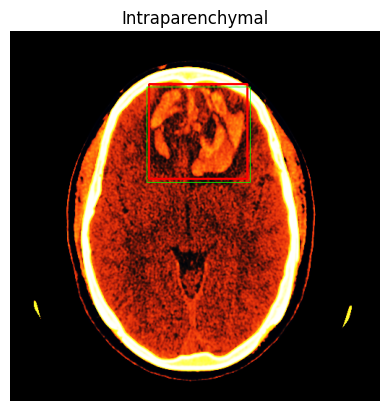

{'x': 245.4567, 'y': 161.76023, 'width': 23.83075, 'height': 44.77292}
245 161 23 44


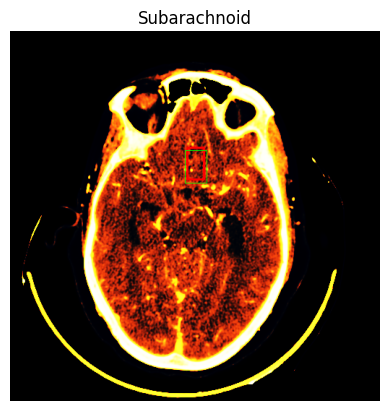

{'x': 278.96471, 'y': 390.02353, 'width': 93.36471999999999, 'height': 48.941159999999996}
278 390 93 48


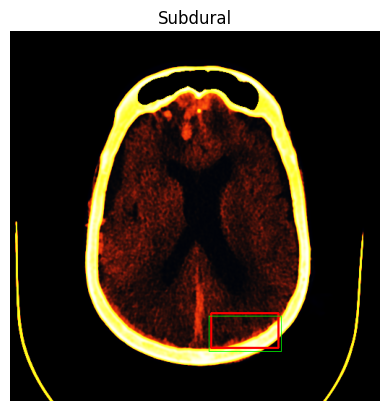

{'x': 185.47191, 'y': 73.34831, 'width': 46.02248, 'height': 25.16854}
185 73 46 25


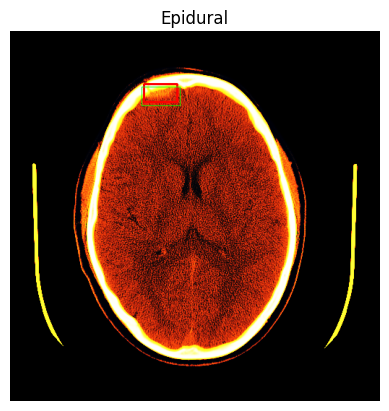

/opt/conda/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (16-bit) doesn't match the JPEG 2000 data (14-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


{'x': 168.1873, 'y': 260.69394, 'width': 59.937940000000005, 'height': 101.10013000000001}
168 260 59 101


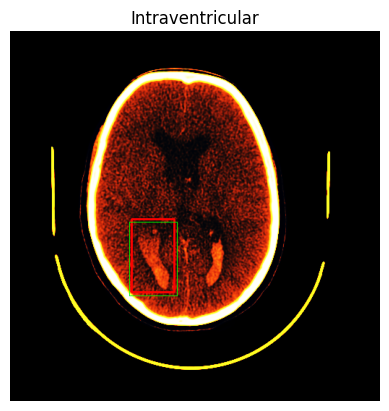

{'x': 145.0787, 'y': 81.60226, 'width': 223.86459, 'height': 184.14668}
145 81 223 184


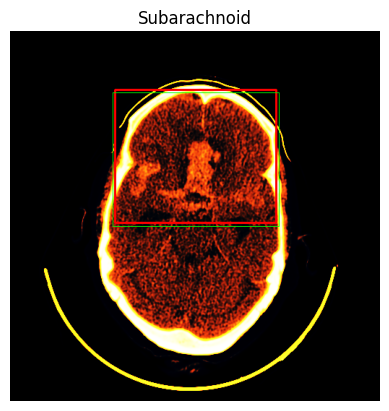

{'x': 230.30712999999997, 'y': 315.74365, 'width': 29.71704, 'height': 101.53326}
230 315 29 101


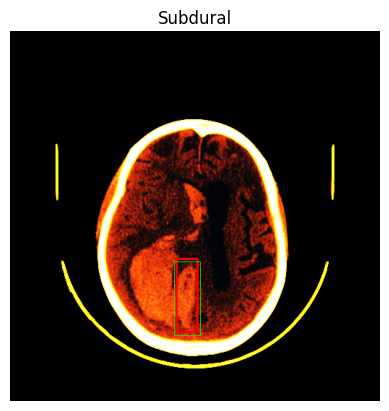

{'x': 255, 'y': 240, 'width': 102, 'height': 169}
255 240 102 169


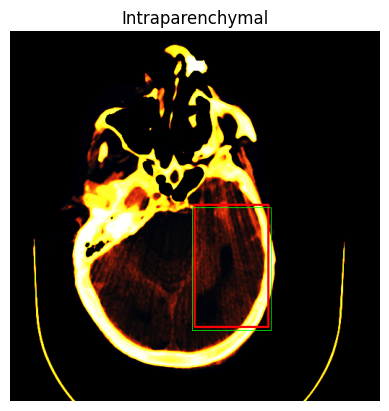

{'x': 280.74802, 'y': 180.94453000000001, 'width': 77.08398000000001, 'height': 79.51823}
280 180 77 79


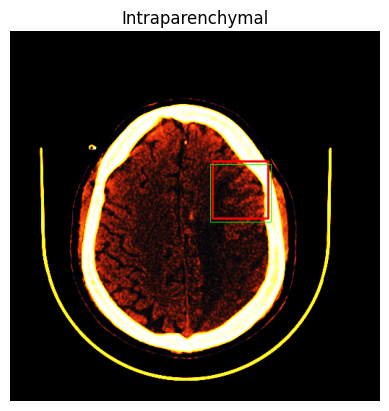

{'x': 249.06741, 'y': 183.42453999999998, 'width': 13.72073, 'height': 24.552889999999998}
249 183 13 24


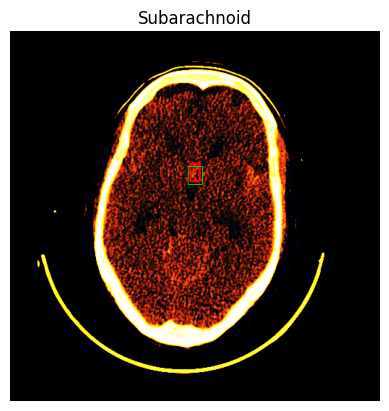

{'x': 116, 'y': 190, 'width': 242, 'height': 181}
116 190 242 181


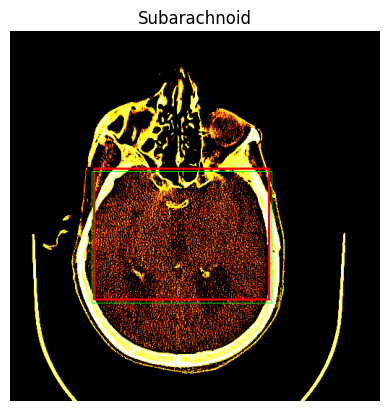

{'x': 249.06741, 'y': 183.42453999999998, 'width': 13.72073, 'height': 24.552889999999998}
249 183 13 24


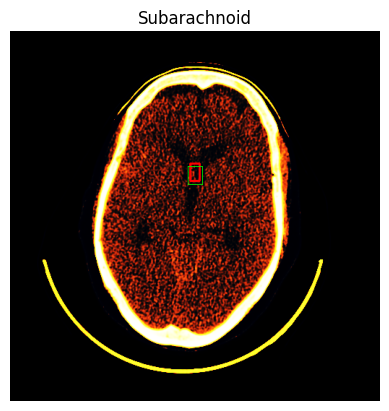

{'x': 152.30015, 'y': 176.2031, 'width': 104.71085, 'height': 236.14104}
152 176 104 236


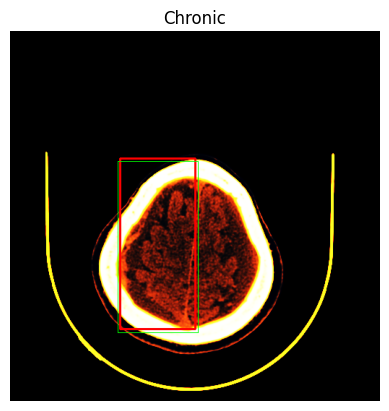

{'x': 178.2809, 'y': 196.31461000000002, 'width': 66.8764, 'height': 127.28091}
178 196 66 127


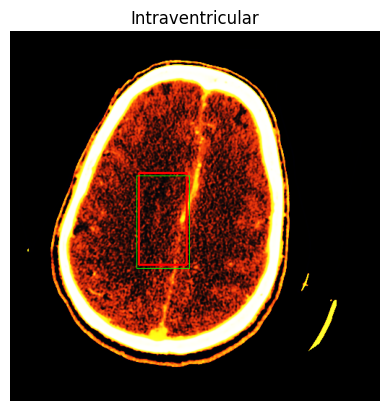

{'x': 346.47227000000004, 'y': 210.96672, 'width': 34.89066, 'height': 51.930279999999996}
346 210 34 51


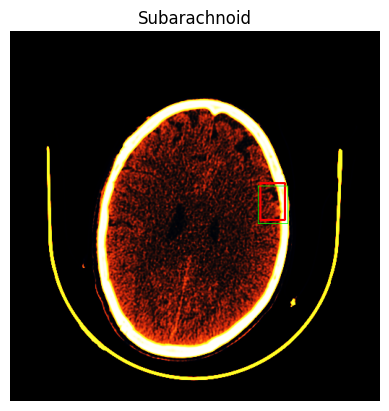

{'x': 324.89412000000004, 'y': 136.28235, 'width': 16.564729999999997, 'height': 17.31766}
324 136 16 17


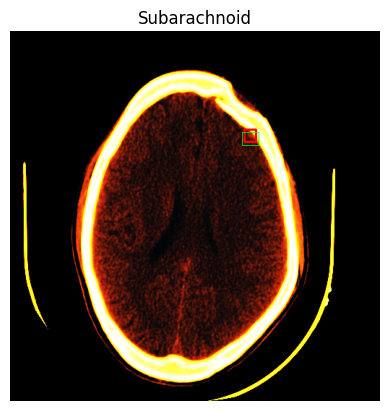

{'x': 266.56046000000003, 'y': 171.88051000000002, 'width': 56.80795, 'height': 187.17497}
266 171 56 187


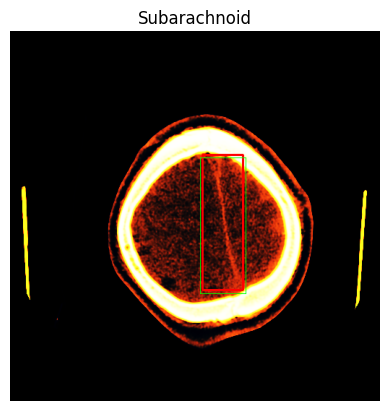

{'x': 334.93591000000004, 'y': 255.69045, 'width': 37.765409999999996, 'height': 30.95528}
334 255 37 30


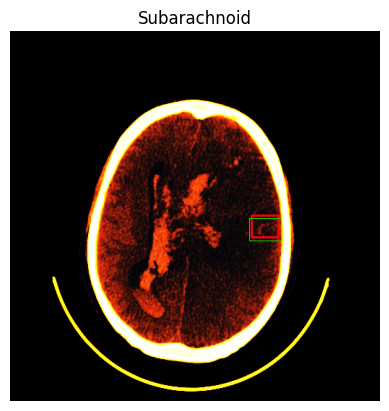

{'x': 158.86517, 'y': 222.20225, 'width': 61.1236, 'height': 81.25842}
158 222 61 81


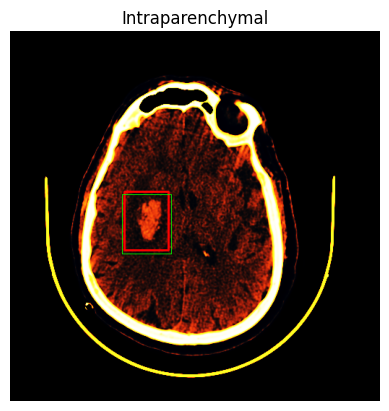

{'x': 143.76404, 'y': 275.41575, 'width': 39.55057, 'height': 32.35953}
143 275 39 32


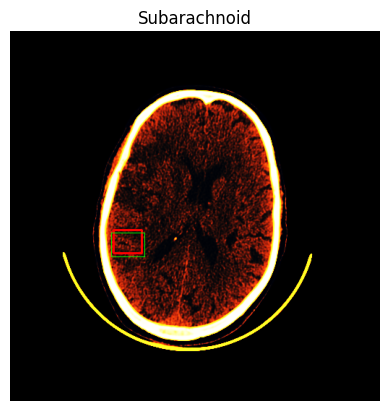

{'x': 263.13482999999997, 'y': 97.79775, 'width': 125.1236, 'height': 274.69662999999997}
263 97 125 274


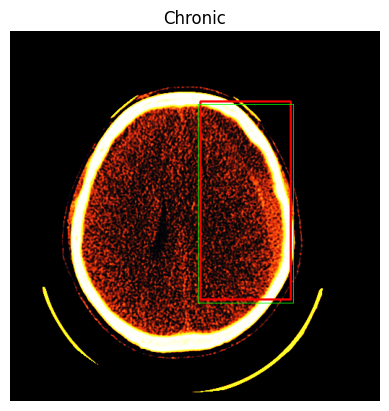

{'x': 259.53933, 'y': 157.48311999999999, 'width': 99.23593000000001, 'height': 247.37081}
259 157 99 247


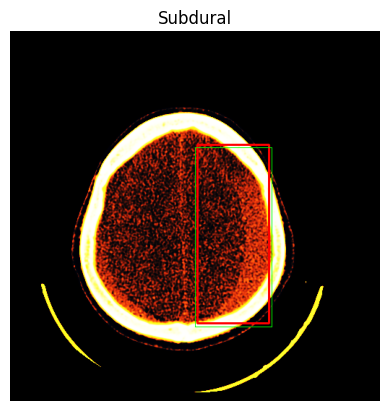

{'x': 150.95506, 'y': 180.4944, 'width': 135.19099, 'height': 186.96628}
150 180 135 186


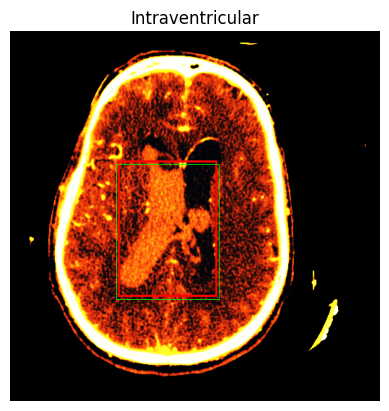

{'x': 108.52808999999999, 'y': 114.33708, 'width': 51.05618, 'height': 83.41573000000001}
108 114 51 83


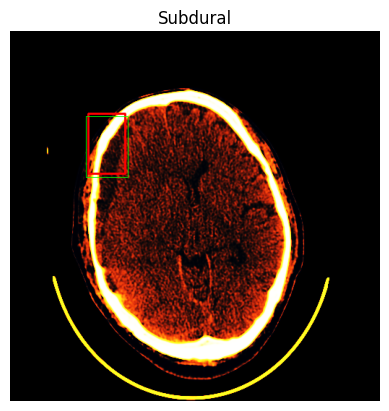

{'x': 231.60171, 'y': 67.73258, 'width': 32.77382, 'height': 77.20057}
231 67 32 77


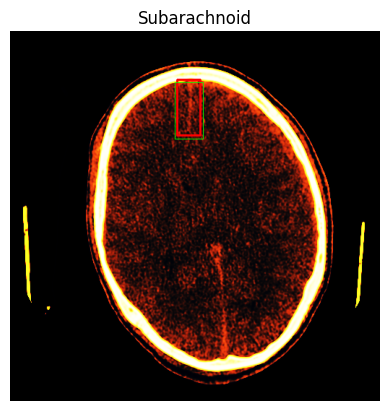

{'x': 204.16853999999998, 'y': 128.7191, 'width': 92.04494, 'height': 87.01123}
204 128 92 87


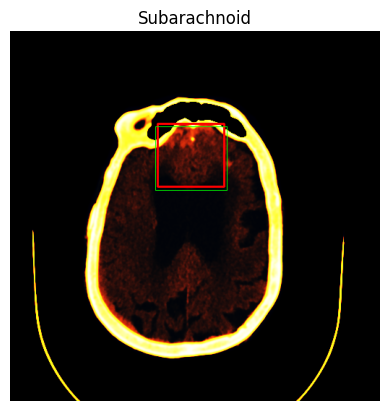

{'x': 170.37079, 'y': 223.64045, 'width': 61.1236, 'height': 115.05618}
170 223 61 115


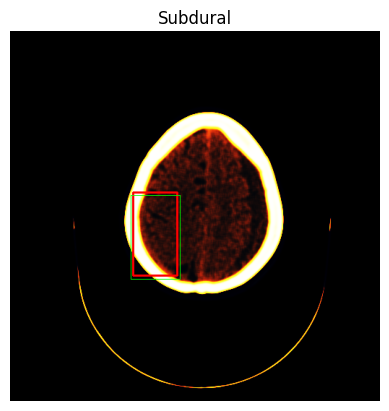

{'x': 207.04494, 'y': 234.42697, 'width': 46.02248, 'height': 84.85391}
207 234 46 84


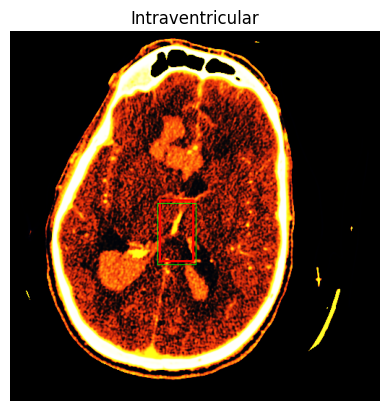

{'x': 123, 'y': 368, 'width': 93, 'height': 81}
123 368 93 81


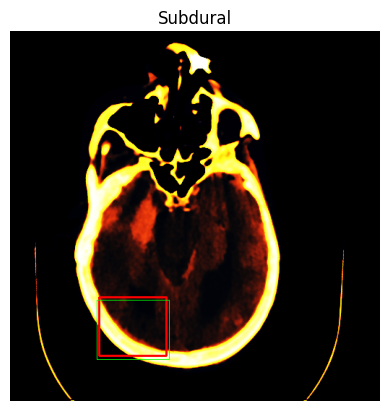

{'x': 112.82959, 'y': 79.82596, 'width': 101.73169, 'height': 75.74185}
112 79 101 75


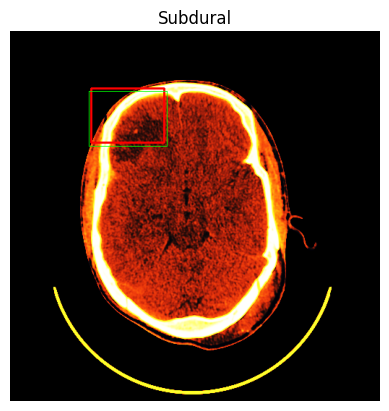

{'x': 249.47191, 'y': 245.93257999999997, 'width': 56.089890000000004, 'height': 53.932590000000005}
249 245 56 53


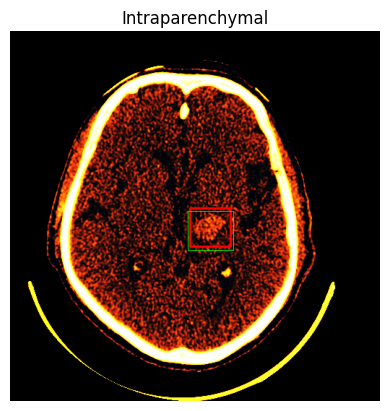

{'x': 214.40451000000002, 'y': 94.60085, 'width': 121.32016000000002, 'height': 100.37799}
214 94 121 100


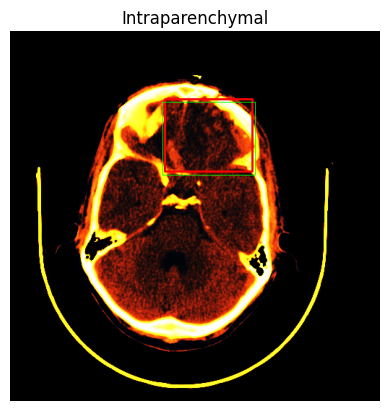

{'x': 105, 'y': 263, 'width': 115, 'height': 182}
105 263 115 182


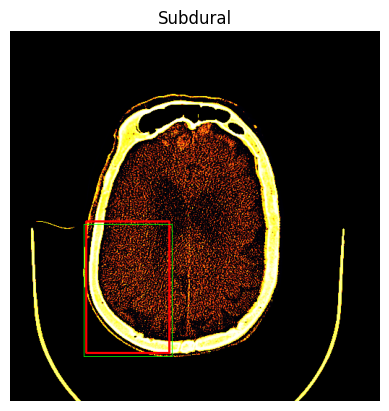

{'x': 132.97752, 'y': 289.79775, 'width': 109.30338, 'height': 143.82022}
132 289 109 143


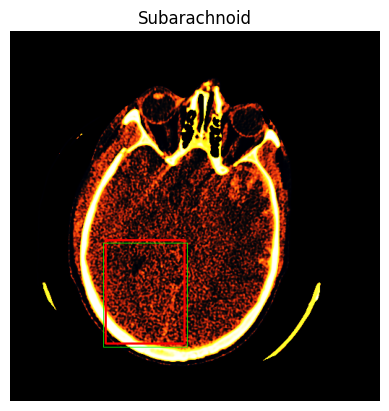

{'x': 206.287, 'y': 226.72646, 'width': 76.91478000000001, 'height': 78.06279}
206 226 76 78


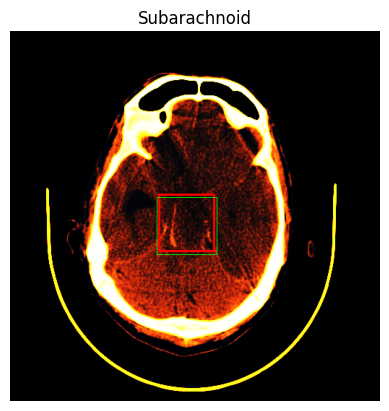

{'x': 176.8427, 'y': 194.8764, 'width': 99.95506, 'height': 139.50562}
176 194 99 139


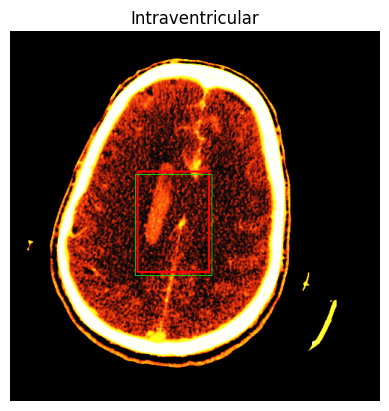

{'x': 309.98115, 'y': 354.94706, 'width': 24.87601, 'height': 29.7027}
309 354 24 29


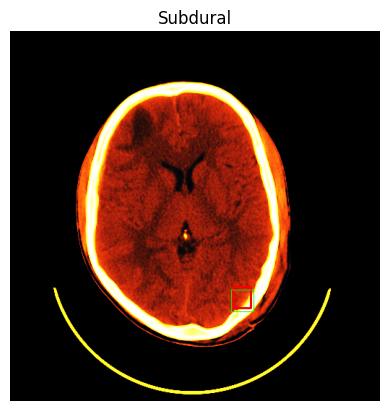

{'x': 266.39887000000004, 'y': 398.62341000000004, 'width': 27.441470000000002, 'height': 19.497889999999998}
266 398 27 19


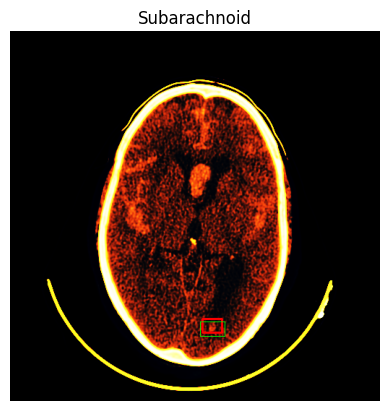

{'x': 171.79802, 'y': 375.51481, 'width': 42.60649, 'height': 25.99719}
171 375 42 25


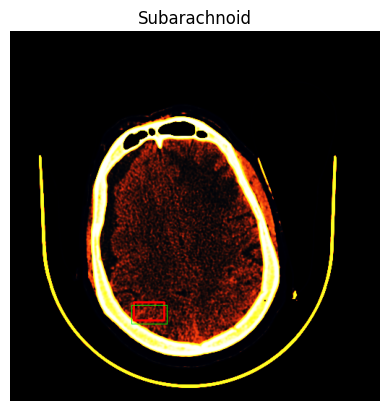

{'x': 173.2472, 'y': 355.95505, 'width': 27.32583, 'height': 28.76405}
173 355 27 28


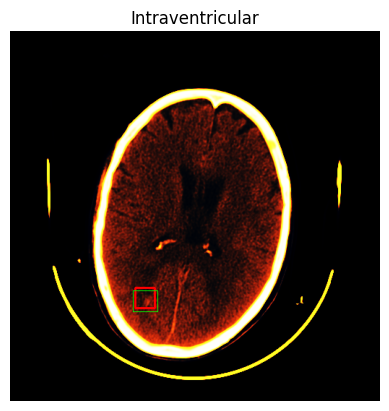

{'x': 253.36471, 'y': 421.64705999999995, 'width': 67.01176, 'height': 27.858829999999998}
253 421 67 27


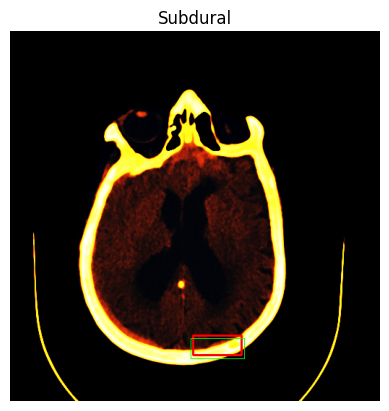

{'x': 113.5618, 'y': 152.44943999999998, 'width': 117.21349, 'height': 116.49438}
113 152 117 116


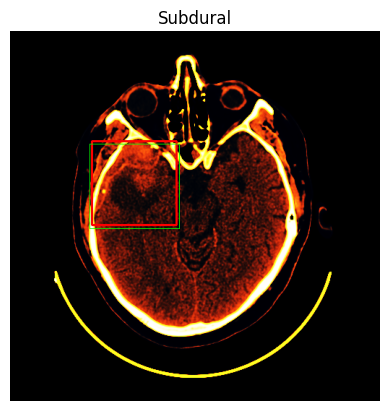

{'x': 160.30337, 'y': 293.39326, 'width': 137.3483, 'height': 119.37078999999999}
160 293 137 119


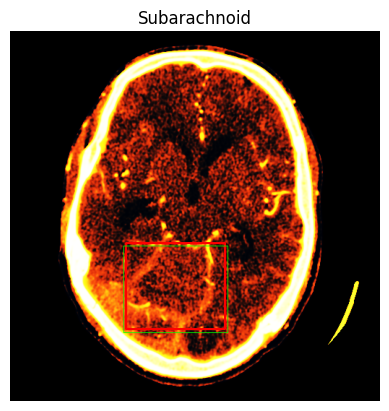

{'x': 146, 'y': 180, 'width': 58, 'height': 172}
146 180 58 172


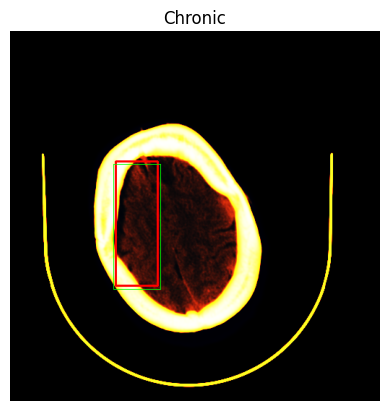

{'x': 256.66292000000004, 'y': 94.20225, 'width': 93.48312, 'height': 102.83145999999999}
256 94 93 102


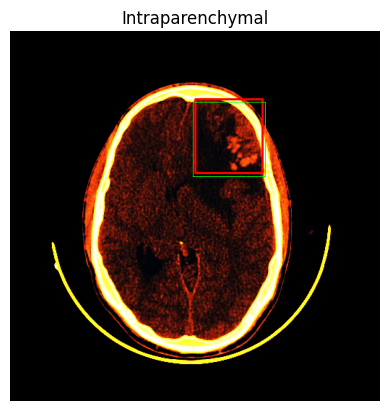

{'x': 199.23948000000001, 'y': 361.79408, 'width': 44.050779999999996, 'height': 54.1608}
199 361 44 54


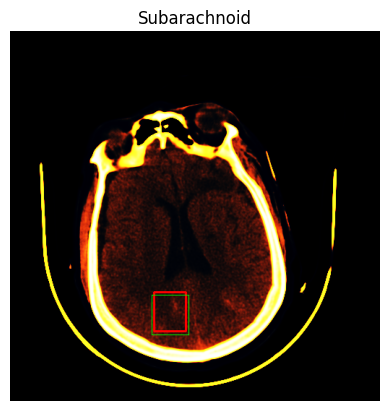

{'x': 137.85726, 'y': 73.65867, 'width': 244.80676, 'height': 207.97743}
137 73 244 207


In [ ]:
import matplotlib.pyplot as plt
import cv2
import json

# Assuming train_df is your DataFrame with columns 'Image_Path', 'labelName', and 'data'
for i in range(70):
    try:
        p = train_df['Image_Path'].iloc[i]  # Get the path to the DICOM image
        k = preprocess(str(p), type="SIGMOID_BSB")  # Preprocess the DICOM image

        label = train_df['labelName'].iloc[i]  # Get the label
        s = train_df['data'].iloc[i]
        print(s)
        bbox_data = json.loads(s.replace("'", "\""))  # Parse bounding box data (assuming it's in JSON format)

        # Extract bounding box coordinates
        x = int(bbox_data['x'])  # Left coordinate
        y = int(bbox_data['y'])  # Top coordinate
        w = int(bbox_data['width'])  # Width
        h = int(bbox_data['height'])  # Height
        print(x,y,w,h)
        # Draw the bounding box on the image
        cv2.rectangle(k, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.rectangle(k, (x-3, y+4), (x + w+4, y + h+5), (0, 255, 0), 1)
        # Display the image with the bounding box
        plt.imshow(k, cmap='gray')
        plt.title(label)  # Set the title to the label
        plt.axis('off')  # Turn off axis labels
        plt.show()
    except Exception as e:
        pass


# preprocess done . Now model building

In [ ]:
def DenseNet():
    densenet = DenseNet121(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    weights='imagenet',
    include_top=False)
    return densenet
def ResNet():
    resnet = ResNet50V2(weights="imagenet",include_top=False)
    return resnet
def Inception():
    incept = InceptionV3(weights="imagenet",include_top=False)
    return incept

def get_backbone(name):
    if name == "RESNET":
        return ResNet
    elif name == "DENSE":
        return DenseNet
    elif name == "INCEPT":
        return Inception

def build_model(backbone):
    m = backbone()
    x = m.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.3)(x)
    pred = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=m.input, outputs=pred)
    return model

In [ ]:

# Define your data loader class
class DataLoader(Sequence):
    # Constructor
    def __init__(self, dataframe, batch_size, shuffle, classes, input_shape, num_classes=6, steps=None, prep="BSB"):
        # Initialize variables
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.classes = classes
        self.current_epoch = 0
        self.prep = prep
        self.steps = steps
        
        if self.steps is not None:
            self.steps = np.round(self.steps / 3) * 3
            self.undersample()

    # Undersample the dataset
    def undersample(self):
        part = np.int(self.steps / 3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["labelName"] == "0"].index.values, size=10000, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["labelName"] != "0"].index.values, size=10000, replace=True)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)

    # Define the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3 * np.int(self.steps / 3)

    # Called at the end of an epoch
    def on_epoch_end(self):
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1

    # Should return a batch of images
    def __getitem__(self, item):
        # Select the ids of the current batch
        current_ids = self.data_ids[item * self.batch_size:(item + 1) * self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y

    # Collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            image = preprocess(ident, self.prep)
            X[idx] = image
            y[idx] = self.__get_target(ident)
        return X, y

    # Extract the targets of one image id
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets


In [ ]:
print(train_df.shape)
print(valid_df.shape)

train_df_len=train_df.shape[0]
valid_df_len=valid_df.shape[0]


In [ ]:
def load_and_preprocess_data(df,length):
    images = []
    labels = []
    bounding_boxes = []
    for i in range(length):
        try:
            image_path = df['Image_Path'].iloc[i]  # Get the path to the DICOM image
            img = preprocess(str(p), type="SIGMOID_BSB")  # Preprocess the DICOM image

            label = df['labelName'].iloc[i]  # Get the label
            s = df['data'].iloc[i]
            bounding_box = json.loads(s.replace("'", "\""))  # Parse bounding box data (assuming it's in JSON format)
            
#             # Extract bounding box coordinates
#             x = int(bbox_data['x'])  # Left coordinate
#             y = int(bbox_data['y'])  # Top coordinate
#             w = int(bbox_data['width'])  # Width
#             h = int(bbox_data['height'])  # Height
            images.append(img)
            labels.append(label)
            bounding_boxes.append(bounding_box)

        except :
            pass
    
        

    return np.array(images), labels, np.array(bounding_boxes)

X_train, y_train, bounding_boxes_train = load_and_preprocess_data(train_df,train_df_len)
X_valid, y_valid, bounding_boxes_valid = load_and_preprocess_data(valid_df,valid_df_len)

y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

model = build_model(get_backbone("RESNET"))

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Save the model weights
model.save_weights("your_model_weights.h5")

# Save the entire model (including architecture) for later use
model.save("your_model.h5")